# Prepare files

In [382]:
# unfortunately I don't have API key for using python API directly so let's download files manually
import pandas as pd
pd.set_option('display.max_columns', 100)
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme(font_scale=2.0)
from cmapPy.pandasGEXpress import parse
import os

#create data storage folder for convenience
if not os.path.exists('data/'):
    os.makedirs('data/')


In [ ]:
#download lvl5 perturbation data - this is a 33Gb file, so it would be nice if you already have it.
pert_path = '/tank/projects/kriukov_cmap/level5_beta_trt_cp_n720216x12328.gctx'   #<--- PLEASE, put your path to perturbation file here
#if not this file
#!wget "https://s3.amazonaws.com/macchiato.clue.io/builds/LINCS2020/level5/level5_beta_trt_cp_n720216x12328.gctx"

#download cmap genes
!wget -P data/  "https://s3.amazonaws.com/macchiato.clue.io/builds/LINCS2020/geneinfo_beta.txt"
#download cmap compounds
!wget -P data/ "https://s3.amazonaws.com/macchiato.clue.io/builds/LINCS2020/compoundinfo_beta.txt"
#download signatures info
!wget -P data/ "https://s3.amazonaws.com/macchiato.clue.io/builds/LINCS2020/siginfo_beta.txt"

In [1]:
genes = pd.read_csv('./data/geneinfo_beta.txt', sep='\t', index_col=0)
comps = pd.read_csv('./data/compoundinfo_beta.txt', sep='\t', index_col=0)
signs = pd.read_csv('./data/siginfo_beta.txt', sep='\t', index_col='sig_id', low_memory=False)

In [191]:
#extract landmark genes and n compounds for the following analysis and time/memory economy
n = 15 #number of top compounds - this number may decrease after filtering

lm = genes[genes.feature_space == 'landmark']
lm.index = lm.index.astype(str)
top_compounds_by_pert_count = signs.groupby('pert_id')['pert_id'].count().sort_values(ascending=False).index[:n].tolist()
cp = comps.loc[comps.index.intersection(top_compounds_by_pert_count)]
#filter signatures
sg = signs[signs.pert_id.isin(cp.index)]
sg = sg[sg.is_hiq == 1] #only high quality samples in the analysis
sg = sg.loc[sg[['pert_itime', 'pert_idose', 'cell_iname']].dropna(axis=0).index]
#preprocess features
sg['TIME'] = np.log2(sg.pert_itime.str.split(' ', expand=True)[0].astype(float))
sg['DOSE'] = np.log10(sg.pert_idose.str.split(' ', expand=True)[0].astype(float))

print("%d unique compounds left after filtration." % sg.pert_id.unique().shape[0])

12 unique compounds left after filtration.


In [192]:
# parse gene expression table (may take several minutes)
df = parse.parse(pert_path, rid=lm.index, cid=sg.index).data_df

# Data harmonization

## Model-intercept based approach

In [216]:
#data harmonization procedure
from statsmodels.stats.multitest import multipletests
import statsmodels.api as sm
from patsy import dmatrices
from scipy.stats import combine_pvalues
from tqdm import tqdm
from multiprocessing import Pool

itable = pd.DataFrame(columns=lm.index, index=sg.pert_id.unique()) #table for appending intercept values gene expression
ptable = pd.DataFrame(columns=lm.index, index=sg.pert_id.unique()) #same for pvalue

def fit_expression_one_intercept(arg):
    c, g = arg #pert_id and gene EntrezID
    tmp = sg[sg.pert_id==c]
    factors = tmp[['TIME', 'DOSE', 'cell_iname']]
    c_data = df[tmp.index]
    y = c_data.loc[g]
    y.name = 'expression'
    design = pd.merge(y, factors, left_index=True, right_index=True)
    y, X = dmatrices('expression ~ TIME + DOSE + cell_iname', data=design, return_type='dataframe')
    mod = sm.OLS(y, X) 
    OLS_result = mod.fit()
    return OLS_result.params['Intercept'], OLS_result.pvalues['Intercept'] #extract intercept value and p-value 

pairs = [(c, g) for c in sg.pert_id.unique() for g in lm.index.tolist()]
#Parallel processing save some time
pool = Pool(40) 
pool_g_result = pool.map(fit_expression_one_intercept, pairs)

#fill tables
for (c, g), (i, p) in zip(pairs, pool_g_result):
    itable.loc[c, g] = i
    ptable.loc[c, g] = p

Despite the parallel call of the function `fit_expression_one_intercept`, this solution still remains the performance 
bottleneck of the whole analysis. The possible solution could lie in avoiding slow python `statsmodels` framework. 
It can be achieved by using R pipeline for DE analysis instead of python one, for instance with `limma` package.

In [410]:
#aggregate pvalues with stouffer z-score method and apply multiple testing correction to exclude ambiguous compounds
agg_pval = [combine_pvalues(ptable.iloc[i].tolist(), method='stouffer')[1] for i in range(ptable.shape[0])]
passed_compounds = multipletests(agg_pval, method='fdr_bh', alpha=0.05)[0]
itable_final = itable[passed_compounds].astype(float)

In [411]:
#just look at the resulting table
itable_final.head(5)

#this is a harmonized dataset prepared for the following analysis

gene_id,16,23,25,30,39,47,102,128,142,154,178,207,211,226,230,291,310,323,329,332,348,351,355,387,392,427,466,481,501,533,572,581,595,596,622,637,642,644,652,664,665,670,672,695,701,727,780,808,813,823,...,66008,79006,79071,79073,79080,79090,79094,79143,79170,79174,79187,79600,79643,79716,79850,79902,79921,79947,79961,80204,80212,80347,80349,80746,80758,81533,81544,83743,84159,84617,84722,84890,85236,85377,89910,90861,91137,91949,93487,93594,94239,116832,124583,147179,148022,200081,200734,256364,375346,388650
BRD-K81418486,-2.826018,-2.286712,-1.897774,2.326226,3.427604,1.389320,-1.466952,1.933214,-1.445518,2.962661,0.152530,0.676004,3.348231,-1.130693,0.799979,-0.884427,2.028431,0.172169,-1.280543,2.571498,-1.023281,-1.277278,0.529914,-0.671366,-1.462606,0.172552,-5.691402,1.967457,-1.938340,0.616148,1.461728,-0.408238,-1.945393,-0.906010,1.945976,0.009508,-0.937761,1.642682,0.053226,2.756557,3.203604,-1.207799,0.154548,0.373477,-0.461731,2.146457,-0.733592,-1.314542,0.509501,0.220107,...,1.654984,-1.410185,0.370687,-2.277382,0.527886,0.051166,-0.919807,1.044615,0.482889,-0.535059,-2.864103,-0.802969,-0.781243,1.590519,-3.360797,2.670182,2.215131,1.949891,1.121354,-0.431700,0.575368,-2.754075,0.739030,-0.270858,-1.371452,-0.415644,-0.373814,-1.949298,2.387072,-1.585446,0.999660,-1.969954,-2.917911,-1.429166,-0.375177,-1.470592,-1.676747,-2.202519,-2.526113,0.944114,0.084508,0.231056,0.077383,1.536844,-0.877120,-2.581570,-0.830289,-1.150718,1.306732,-0.513815
BRD-K21680192,1.060822,-2.702418,-0.301852,0.308257,-0.152705,1.076980,1.536088,-2.755125,1.450404,1.174950,0.512637,1.132839,-4.409352,1.218407,0.278565,1.820588,-0.031118,-1.115150,-0.522513,3.267737,-0.106148,-1.463282,2.066370,1.335231,0.425678,-0.712998,1.485604,-0.172130,0.062366,-0.489754,-0.092415,0.084923,0.645833,3.068950,0.240493,-0.253273,1.481752,2.730077,0.283827,1.984756,0.860246,-0.660390,1.064013,0.705572,-1.190148,2.059974,0.614228,-1.035156,0.101566,-0.597226,...,0.647195,0.987521,3.287968,-0.635183,2.205706,-0.713473,-0.342366,-2.804299,-0.642886,1.239328,-1.807041,1.177421,1.462882,-0.702249,-1.459242,-0.164041,0.108688,-3.391048,0.901467,0.847658,0.969765,0.224612,-0.700211,1.361950,0.505681,-0.946302,1.529836,0.901545,-1.140194,0.466089,-2.274670,2.138089,-1.056711,1.741704,2.727817,1.258670,-1.248270,0.187150,-2.600631,2.494906,-2.010975,0.770505,-3.384664,-2.798946,-3.386010,-0.126200,-1.335700,-0.266828,-1.226043,-0.893117
BRD-A75409952,3.128850,-1.550881,-3.188456,-0.754895,0.436587,0.236069,1.989639,-1.225848,-4.822476,-0.546263,-0.752764,-0.397193,-1.650512,0.228412,-1.956894,-4.312627,2.162358,2.389855,1.674567,3.726701,-1.022829,0.259790,0.385147,4.228259,-0.288631,-1.285528,1.665504,-0.373120,-0.144133,-0.622730,-2.645866,-2.647491,-3.628079,1.051196,-2.043955,-0.698009,-0.426389,-0.305469,-1.027989,1.876285,7.776901,-0.478152,1.941608,-1.444041,0.278063,-0.754983,0.505093,-0.699298,-1.729904,-0.775709,...,1.783316,-1.367865,-1.904352,-5.537483,-4.724865,-2.492744,-0.493333,-1.352610,0.029586,-1.604137,-1.370271,1.620118,-1.744462,-1.978229,-1.261987,-3.050064,-1.901181,-0.913458,-0.482227,-0.502366,-0.422946,-2.020582,-1.913488,-2.106572,-2.960497,-1.699166,1.993476,-2.475433,0.150936,0.678677,1.982909,-2.492125,0.352190,3.049010,0.088264,2.467250,1.009188,-0.526737,-1.933118,1.787943,0.738284,1.708113,-1.095854,0.881736,0.262780,-2.797445,-0.767756,-2.649373,0.266211,-1.323401
BRD-A19037878,-4.084303,-2.447400,-3.936585,2.055870,3.595893,-1.165413,-0.968756,1.441076,-2.425898,5.455878,0.526854,1.815909,5.519206,-1.275415,4.738781,-1.928292,2.213146,-0.113437,-1.919853,1.949643,-0.265298,-0.051362,-0.379710,1.203964,-3.170299,0.639618,-6.477730,2.046264,-2.105091,-0.173781,3.698072,-0.667870,-2.548219,-1.761906,1.888529,-0.125127,-1.828717,2.278820,0.834376,5.160199,6.995293,-1.160450,-1.773537,0.030551,-0.281351,2.811842,1.042038,-0.789982,0.804004,1.630596,...,3.664539,-1.370760,0.964096,-1.654917,-0.266049,1.322823,-0.486983,2.636663,0.

## Naive approach

In [412]:
#naive harmonization approach: just average all signatures with the same pert_id
itable_naive = df.T.loc[sg.index].groupby(sg.pert_id).mean()
itable_naive.head()

rid,10007,1001,10013,10038,10046,10049,10051,10057,10058,10059,10099,10112,10123,10131,10146,10150,10153,10165,1017,10174,10180,1019,10190,102,10206,1021,1022,10221,10227,10237,10245,1026,1027,10270,10273,10276,10285,1029,10298,10318,10320,10329,10362,10398,10434,10450,10451,10489,10491,10493,...,9533,9552,958,960,9637,9641,965,9650,9653,9670,9686,9688,9690,9695,9697,9702,9703,9709,9710,9712,9738,976,9761,9797,9801,9805,9813,9817,983,9833,9842,9847,9851,9854,9868,9897,9903,991,9915,9917,9918,9924,9926,9928,993,994,9943,9961,998,9988
pert_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
BRD-A19037878,-2.338777,-0.095989,2.044327,-3.487224,1.072492,0.541523,-4.179938,0.808073,1.510914,0.143993,1.257638,-4.360307,1.661005,-0.505361,-2.045403,0.577627,0.028863,-2.485554,0.726443,-3.390368,2.061182,-4.976506,-1.346158,1.718023,-0.400027,-1.402633,1.786642,-0.463009,-0.567955,-2.605682,-0.555396,5.422998,-3.727590,-3.210967,1.994196,-0.521661,-2.150303,-1.676721,-1.170317,-2.383928,0.500628,-1.105310,2.243701,0.630045,-1.665334,-1.385343,0.065766,-4.578056,-2.588216,2.600466,...,-0.048962,-4.917704,0.813925,-1.525132,-0.988247,-0.858665,-3.259809,0.771910,1.266821,1.252525,-1.964930,2.069445,0.341411,0.379185,0.860510,0.211280,0.629426,1.701984,1.082823,-0.180505,1.447399,-1.274281,1.952718,-0.999960,-2.879768,-4.213388,1.738517,-7.876278,-4.143166,-2.683982,1.123391,-3.341941,0.004844,3.849770,0.792294,1.638061,1.326399,-3.203468,0.391239,-0.995707,-0.338901,-0.010483,-3.693879,-0.965544,-3.369810,-2.182930,-0.256683,1.797715,-0.873111,0.383188
BRD-A19500257,-0.514149,0.606971,-0.011118,-1.064014,0.259396,1.329000,-0.702479,1.096840,-0.498619,-0.800802,0.367016,-0.061615,0.031368,-1.100757,-0.773879,1.191622,0.046798,-0.481306,-1.314403,0.362960,0.409212,-2.000724,-1.057687,1.119943,0.465705,0.012040,1.814704,-0.395768,-0.254662,1.291457,-0.373525,-0.044580,-0.176203,0.538069,-1.942546,0.003551,1.396066,-0.084824,0.870040,0.130918,0.588855,-1.829068,0.244244,0.404698,-0.726002,0.254185,1.342630,0.525525,0.787330,-0.439070,...,0.019102,1.623608,0.306537,-0.313728,0.045954,-0.737345,-0.691017,0.442063,0.254636,0.211633,-0.406908,-1.072842,-0.844786,1.570705,0.629819,0.721250,0.005146,1.908154,0.372717,0.460294,-0.085330,-0.407917,0.422761,-0.074731,-0.423926,-0.679394,1.632706,0.226636,-0.672890,-1.304244,0.210127,-1.345514,0.623591,-0.175472,1.052672,0.197442,0.220788,-1.549242,0.129988,0.930672,0.650071,-0.015498,-0.076483,-0.025395,-1.487964,-0.949261,-0.498130,-0.076286,-0.367728,-0.428071
BRD-A75409952,0.000818,0.265974,0.876910,-1.607057,0.385118,0.022758,-1.293067,0.484964,-0.372158,-1.008573,0.102967,-2.423954,0.469480,-0.590096,-0.987480,0.400413,-0.529263,-0.198072,-0.414301,0.208082,0.182659,-0.563252,-1.346907,0.670488,0.424577,-0.274824,0.654081,1.058585,0.426527,-0.845838,0.191083,0.483860,0.347505,0.080880,-0.245436,0.912708,-0.469951,0.244205,-0.477106,1.022792,0.312495,-0.097008,0.190164,0.025559,-0.546408,-0.229210,0.444728,0.201225,0.128051,1.027160,...,-0.262912,0.507949,0.324074,0.484141,0.274594,0.591328,-0.174412,0.002832,0.173079,0.255582,0.599224,-1.299964,-0.394800,0.529287,-0.052043,0.392906,0.119667,0.264283,0.961671,0.554702,-0.335202,0.650548,-0.469222,-0.262410,-1.279231,0.075407,0.664620,0.413816,-2.000651,-0.819876,0.613696,0.497797,0.572338,-0.058662,-0.600957,0.538953,1.046444,-3.110471,0.300932,-0.031750,-0.469836,0.520426,0.361939,-1.287619,-1.925045,-0.812303,-0.057990,1.581494,-0.622703,0.605306
BRD-A79768653,0.404835,0.135844,1.252556,-1.311029,0.422763,0.067547,-0.527583,0.548652,-0.409992,-1.200050,0.042339,-0.669322,0.353250,-0.496978,-0.323620,0.737711,-0.427353,-0.385513,-0.604871,0.401008,0.216481,-0.677309,-0.551504,0.337137,0.423754,0.066884,0.090261,0.852426,0.342139,-0.152924,0.576310,0.033975,0.707650,-0.379742,-0.530396,-0.215022,-0.898532,-0.193388,-0.342773,0.640901,0.307356,0.041900,-0.034526,0.496378,-0.276043,-0.219240,0.12

# Similarity analysis

In [413]:
#here we get pubchem similarity matrix
from rdkit import Chem
from rdkit import DataStructs

smiles = comps.loc[itable_final.index, 'canonical_smiles'].unique().tolist()
mols = [Chem.MolFromSmiles(m) for m in smiles]
fps = [Chem.RDKFingerprint(x) for x in mols]

sim = pd.DataFrame(0, columns=itable_final.index, index=itable_final.index)
for i in range(len(sim)):
    for j in range(i, len(sim)):
        sim.iloc[i,j] = sim.iloc[j,i] = DataStructs.FingerprintSimilarity(fps[i], fps[j])

In [414]:
cor = itable_final.T.corr(method='pearson')

In [415]:
m = cor.shape[0]
ridx,cidx = np.triu_indices(m, 1)
ucor = cor.to_numpy()[ridx, cidx]
usim = sim.to_numpy()[ridx, cidx]

## Simple correlation test

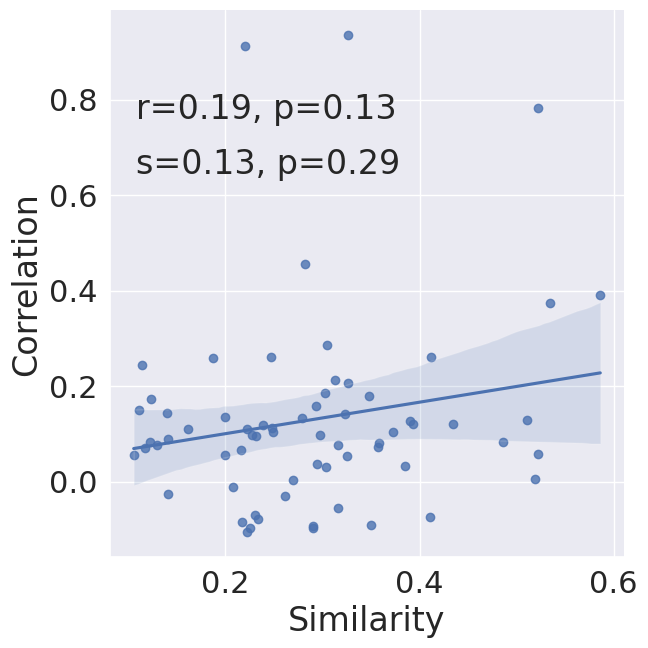

In [416]:
from scipy.stats import pearsonr, spearmanr

data = pd.DataFrame(dict(Similarity=usim, Correlation=ucor))
g = sns.lmplot(x="Similarity", y="Correlation", data=data, ci=95, height=7, aspect=1 );

def annotate(data, **kws):
    r, pr = pearsonr(data['Similarity'], data['Correlation'])
    s, ps = spearmanr(data['Similarity'], data['Correlation'])
    ax = plt.gca()
    ax.text(.05, .8, 'r={:.2f}, p={:.2g}'.format(r, pr),
            transform=ax.transAxes)
    ax.text(.05, .7, 's={:.2f}, p={:.2g}'.format(s, ps),
            transform=ax.transAxes)
    
g.map_dataframe(annotate)
plt.show()

## Two-sample KS test

In [417]:
from scipy.stats import ks_2samp
#just split data by similarity median and test if the distrubutions are the same.
med = np.median(usim)
s1 = ucor[usim <= med]
s2 = ucor[usim > med]

ks_2samp(s1, s2)

KstestResult(statistic=0.18181818181818182, pvalue=0.6543432845812748)

## Repeat for naive approach

In [418]:
cor = itable_naive.T.corr(method='pearson')

m = cor.shape[0]
ridx, cidx = np.triu_indices(m, 1)
ucor = cor.to_numpy()[ridx, cidx]

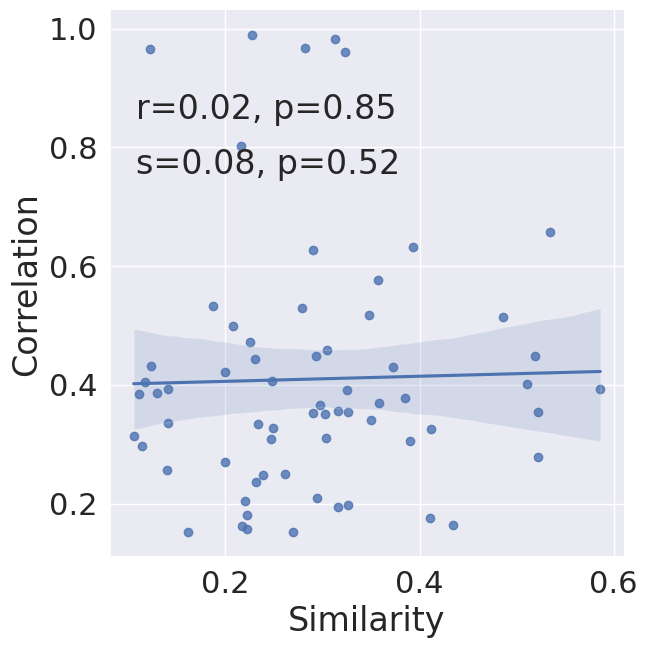

In [419]:
from scipy.stats import pearsonr, spearmanr

data = pd.DataFrame(dict(Similarity=usim, Correlation=ucor))
g = sns.lmplot(x="Similarity", y="Correlation", data=data, ci=95, height=7, aspect=1 );

def annotate(data, **kws):
    r, pr = pearsonr(data['Similarity'], data['Correlation'])
    s, ps = spearmanr(data['Similarity'], data['Correlation'])
    ax = plt.gca()
    ax.text(.05, .8, 'r={:.2f}, p={:.2g}'.format(r, pr),
            transform=ax.transAxes)
    ax.text(.05, .7, 's={:.2f}, p={:.2g}'.format(s, ps),
            transform=ax.transAxes)
    
g.map_dataframe(annotate)
plt.show()

In [420]:
from scipy.stats import ks_2samp
#just split data by similarity median and test if the distrubutions are the same.
med = np.median(usim)
s1 = ucor[usim <= med]
s2 = ucor[usim > med]

ks_2samp(s1, s2)

KstestResult(statistic=0.24242424242424243, pvalue=0.28992386608240617)

# Conclusion

text